In [8]:
# import library
import pandas as pd
import numpy as np 
import matlab 
import matplotlib.pyplot as plt
import os
import numpy as np
from gc import callbacks
import scipy.linalg as la
from sklearn import preprocessing
from distfit import distfit
from sklearn.decomposition import PCA
import sys 
from scipy.optimize import curve_fit
import scipy.constants as constants 


In [ ]:
# read the file
# mortality
zipped = True
if zipped:
    mdf_path = r'data/mdf_final.csv'
    mdf = pd.read_csv(mdf_path, low_memory=False)
    mdf = mdf.drop(columns='Unnamed: 0')
    
    pdf_path = r'data\pdf_final.csv'
    pdf = pd.read_csv(pdf_path, low_memory=False)
    pdf = pdf.drop(columns=['Lb', 'Unnamed: 0'])
    
    lnmrdf = pd.read_csv(r'data/lnmr_final.csv', low_memory=False)
    lnmrdf = lnmrdf.drop(columns='Unnamed: 0')
    
    lnfrdf = pd.read_csv(r'data/lnfr_final.csv', low_memory=False)
    lnfrdf = lnfrdf.drop(columns='Unnamed: 0')
    
    
else:
    mortality_path_7 = r'data/MortIcd7.csv'
    mortality_data_7 = pd.read_csv(mortality_path_7, low_memory=False)

    mortality_path_8 = r'data/MortIcd8.csv'
    mortality_data_8 = pd.read_csv(mortality_path_8, low_memory=False)

    mortality_path_9 = r'data/Morticd9.csv'
    mortality_data_9 = pd.read_csv(mortality_path_9, low_memory=False)

    mortality_path_2002 = r'data/Morticd10_part1.csv'
    mortality_data_2002 = pd.read_csv(mortality_path_2002, low_memory=False)

    mortality_path_2007 = r'data/Morticd10_part2.csv'
    mortality_data_2007 = pd.read_csv(mortality_path_2007, low_memory=False)

    mortality_path_2012 = r'data/Morticd10_part3.csv'
    mortality_data_2012 = pd.read_csv(mortality_path_2012, low_memory=False)

    mortality_path_2016 = r'data/Morticd10_part4.csv'
    mortality_data_2016 = pd.read_csv(mortality_path_2016, low_memory=False)

    mdf = pd.concat([mortality_data_7, mortality_data_8, mortality_data_9, mortality_data_2002, mortality_data_2007, mortality_data_2012, mortality_data_2016], ignore_index=True)
    undesired_mortality_columns = ['Admin1', 'SubDiv', 'Sex', 'List', 'Frmat', 'IM_Frmat', 'Cause', 'IM_Deaths1','IM_Deaths2', 'IM_Deaths3', 'IM_Deaths4'] 
    mdf = mdf.drop(columns = undesired_mortality_columns)

    # population
    pop_path = r'data/pop.csv'
    pdf = pd.read_csv(pop_path, low_memory=False)
    dropped = False
    if not dropped:
        undesired_population_columns = ['Admin1', 'SubDiv', 'Sex', 'Frmat', 'Lb'] 
        pdf = pdf.drop(columns = undesired_population_columns)

# country code
country_code_path = r'data/country_codes.csv'
country_code = pd.read_csv(country_code_path, low_memory=False)
# creating the country code map 
country_code_map = {}
for index, rows in country_code.iterrows():
    country_code_map[rows['country']] = rows['name']

In [ ]:
# needs to swap out the nah columns into averages 
done = True
if not done:
    not_used_country_list = []
    country_num_count = 0
    not_useful = False
    for key in country_code_map:
        country_num_count += 1
        display(country_num_count / len(country_code_map))
        country_mdf = mdf[mdf['Country'] == key]
        
        if country_mdf.empty:
            not_used_country_list.append(key)
        
        else:
            min_year = int(country_mdf['Year'].min())
            max_year = int(country_mdf['Year'].max()) 
            for i in range (min_year, max_year + 1):
                
                if not_useful:
                    break
                
                mask = (mdf['Country'] == key) & (mdf['Year'] == i)
                curr_Year = i

                for c in mdf.columns.values:
                    
                    if not_useful:
                        break
                    
                    average = mdf.loc[mask, c].mean()   
                    
                    max_iter = max_year - curr_Year
                    count = 0 
                    while np.isnan(average):
                        curr_Year += 1
                        count += 1
                        mask_alt = (mdf['Country'] == key) & (mdf['Year'] == curr_Year) 
                        average = mdf.loc[mask_alt, c].mean()   
                        
                        if count > max_iter:
                            not_useful = True
                            break 
                        
                        
                    mdf.loc[mask, c] = mdf.loc[mask, c].fillna(average)
                    curr_Year = i 
                    
            if not_useful:
                display(key)
                not_used_country_list.append(key)
                index = mdf[mdf['Country'] == key].index
                mdf = mdf.drop(index)
                not_useful = False
                
    undesired_mortality_columns = ['Admin1', 'SubDiv', 'Sex', 'List', 'Frmat', 'IM_Frmat', 'Cause', 'IM_Deaths1','IM_Deaths2', 'IM_Deaths3', 'IM_Deaths4'] 
    mdf = mdf.drop(columns = undesired_mortality_columns)            
    mdf = mdf.groupby(['Country', 'Year'], as_index=True).agg("sum").reset_index()
    
    # building the potential country list 
    country_list = list(set(mdf['Country']))
    country_list.sort()
    len(country_list) 
        
            

        

In [ ]:
# build pdf
done = True
if not done:
    not_used_pop_list = []
    country_num_count = 0
    not_useful = False
    for key in country_list:
        
            country_num_count += 1
            display(country_num_count / len(country_list))
            
            country_pdf = pdf[pdf['Country'] == key]
            
            if country_pdf.empty:
                not_used_pop_list.append(key)
            
            else:
                min_year = int(country_pdf['Year'].min())
                max_year = int(country_pdf['Year'].max()) 
                
                if min_year == max_year:
                    if (country_pdf.isnull().sum().sum() > 0):
                        not_useful = True
                    else:
                        continue
                
                for i in range (min_year, max_year + 1):
                    
                    if not_useful:
                        break
                    
                    mask = (pdf['Country'] == key) & (pdf['Year'] == i)
                    curr_Year = i

                    for c in pdf.columns.values:
                        
                        if not_useful:
                            break
                        
                        average = pdf.loc[mask, c].mean()   
                        
                        max_iter = max_year - curr_Year
                        count = 0 
                        while np.isnan(average):
                            curr_Year += 1
                            count += 1
                            mask_alt = (pdf['Country'] == key) & (pdf['Year'] == curr_Year)
                            average = pdf.loc[mask_alt, c].mean()   
                            
                            if count > max_iter:
                                not_useful = True
                                break 
                            
                            
                        pdf.loc[mask, c] = pdf.loc[mask, c].fillna(average)
                        curr_Year = i 
                        
                if not_useful:
                    display(key)
                    not_used_pop_list.append(key)
                    index = pdf[pdf['Country'] == key].index
                    pdf = pdf.drop(index)
                    not_useful = False
                    
    # delete the unused countries 
    for key in not_used_pop_list:
        country_list.remove(key)
        
    # finalizing pdf 
    pdf = pdf[pdf['Country'].isin(country_list)]
    pdf = pdf.groupby(['Country', 'Year'], as_index=True).agg("sum").reset_index()
    pdf.to_csv(r'data/pdf_final.csv')
    
    # finalizing mdf 
    mdf = mdf[mdf['Country'].isin(country_list)]
    mdf.to_csv(r'data/mdf_final.csv')
                    
                
        
    

In [ ]:
# create the log mortality rate graph 

done = True
if not done:
    
    lnmr_dict = {}
    lnmr_dict['Country'] = []
    lnmr_dict['Year'] = []
    for i in range (6, 27):
        lnmr_column = f'Log Mortality{i}'
        lnmr_dict[lnmr_column] = []
    
    lnmrdf = pd.DataFrame(lnmr_dict)
    
    country_list = list(set(mdf['Country']))
    country_list.sort()
    
    country_num_count = 0
    for key in country_list:
        
        country_num_count += 1
        display(country_num_count / len(country_list))
        
        country_mdf = mdf[mdf['Country'] == key]
        min_year = int(country_mdf['Year'].min())
        max_year = int(country_mdf['Year'].max()) 
        
        for i in range (min_year, max_year + 1):
            
            m_mask = (mdf['Country'] == key) & (mdf['Year'] == i)
            p_mask = (pdf['Country'] == key) & (pdf['Year'] == i)
            
            if pdf[p_mask].empty or mdf[m_mask].empty:
                continue
            else:
                lnmrdf.loc[lnmrdf.shape[0]] = ['None'] * lnmrdf.shape[1]
                lnmrdf.loc[lnmrdf.shape[0]-1, ['Country']] = key
                lnmrdf.loc[lnmrdf.shape[0]-1, ['Year']] = i
            
            for c in range(6, 27):
                
                if c == 6:
                    deaths = 0
                    population = 0
                    for j in range (2, 7):
                        m_column = f'Deaths{c}'
                        p_column = f'Pop{c}'
                        lnmr_column = f'Log Mortality{c}'
                        try:
                            deaths += mdf[m_mask][m_column].values.astype('float')[0]
                            population += pdf[p_mask][p_column].values.astype('float')[0]
                        except:
                            display(key)
                            display(i)
                            display(c)
                            callbacks()
                else:
                    m_column = f'Deaths{c}'
                    p_column = f'Pop{c}'
                    lnmr_column = f'Log Mortality{c}'
                    try:
                        deaths = mdf[m_mask][m_column].values.astype('float')[0]
                        population = pdf[p_mask][p_column].values.astype('float')[0]
                    except:
                        display(key)
                        display(i)
                        display(c)
                        callbacks()
                try:
                    ratio = deaths / population
                    lnmrdf.loc[lnmrdf.shape[0]-1, lnmr_column] = np.log(ratio)
                except:
                    display(key)
                    display(i)
                    display(c)
                    callbacks()
    
    lnmrdf.to_csv(r'data/lnmr_final.csv')

In [ ]:
# fit the mortality model 
from numpy import inf


done = True
pred_year = 2050
each_country_num = 50
if not done:
    
    country_list = list(set(lnmrdf['Country']))
    country_list.sort()
    mort_d = {}
    
    for key in country_list:
        
        try: 
        
            display(key)
            c_s = []
            
            country_lnmrdf = lnmrdf[lnmrdf['Country'] == key]
            min_year = int(country_lnmrdf['Year'].min())
            max_year = int(country_lnmrdf['Year'].max())
            
            ma = country_lnmrdf[country_lnmrdf['Year'] > min_year].drop(columns=['Country', 'Year']).values
            mb = country_lnmrdf[country_lnmrdf['Year'] < max_year].drop(columns=['Country', 'Year']).values

            m = np.nan_to_num(ma - mb)
            scaler = preprocessing.StandardScaler().fit(m)
            m_scaled = np.nan_to_num(scaler.transform(m))
            u, singular, V_transpose = np.linalg.svd(m_scaled)
            singular[singular == inf] = sys.float_info.max
            dist = distfit()
            # gamma distribution 
            dist.fit_transform(singular)
            # loading vectors
            pca = PCA(n_components=1)
            transformed_data = pca.fit(m_scaled).transform(m_scaled)
            eigenValues = pca.explained_variance_ratio_
            # loading = pca.components_.T * np.sqrt(pca.explained_variance_)
            loadings = pd.DataFrame(pca.components_.T)
            lv = np.matrix(loadings[0].values)
            y = int((pred_year - max_year)) 
            for i in range (each_country_num):    
                m_new = np.matrix(dist.generate(y)).reshape(y, 1)
                pred = m_new * lv
                c_s.append(pred)
                
            mort_d[key] = c_s
        
        except:
            continue

In [ ]:
# construct log fertility graph 
done = True
if not done:
    
    lnfr_dict = {}
    lnfr_dict['Country'] = []
    lnfr_dict['Year'] = []
    lnfr_dict['Log Fertility'] = []
    
    lnfrdf = pd.DataFrame(lnfr_dict)

    for key in mort_d:
        
        country_pdf = pdf[pdf['Country'] == key]
        country_mdf = mdf[(mdf['Country'] == key)]
        country_mdf = country_mdf[(country_mdf['Year'].isin(country_pdf['Year']))]
        min_year = np.max([int(country_mdf['Year'].min()), int(country_pdf['Year'].min())])
        max_year = np.min([int(country_mdf['Year'].max()), int(country_pdf['Year'].max())])

        for year in range(min_year, max_year):
            
            try:
            
                lnfrdf.loc[lnfrdf.shape[0]] = ['None'] * lnfrdf.shape[1]
                lnfrdf.loc[lnfrdf.shape[0]-1, ['Country']] = key
                lnfrdf.loc[lnfrdf.shape[0]-1, ['Year']] = year
                a = country_pdf[country_pdf['Year'] == year+1]['Pop1'].values[0]
                b = country_pdf[country_pdf['Year'] == year]['Pop1'].values[0]
                d = country_mdf[country_mdf['Year'] == year + 1]['Deaths1'].values[0]
                yp = (a - b + d) / b 
                lnfrdf.loc[lnfrdf.shape[0]-1, 'Log Fertility'] = np.log(yp)
            
            except:
                continue
    
    lnfrdf.to_csv(r'data/lnfr_final.csv')
    

In [ ]:
# fit the fertility model 
done = True
if not done:
    country_list = list(set(lnfrdf['Country']))
    country_list.sort()
    fert_d = {}
    
    for key in country_list:
        display(key)
        c_s = []
        country_lnmrdf = lnmrdf[lnmrdf['Country'] == key]
        max_year = int(country_lnmrdf['Year'].max())
        p = np.nan_to_num(lnfrdf[lnfrdf['Country'] == key]['Log Fertility'].values)
        cp = p[1:] - p[:-1]
        dist = distfit()
        # gamma distribution 
        dist.fit_transform(cp)
        
        
        y = int((pred_year - max_year))
        
        for i in range (each_country_num):    
            pred = np.matrix(dist.generate(y)).reshape(y, 1)
            c_s.append(pred)
        
    
        fert_d[key] = c_s
        
        
    

In [ ]:
# construct the final graph
done = True
first = True
if not done:
    
    for key in mort_d:
        try:
            country_mdf = mdf[mdf['Country'] == key]
            country_pdf = pdf[pdf['Country'] == key]
            country_lnmrdf = lnmrdf[lnmrdf['Country'] == key]
            country_lnfrdf = lnfrdf[lnfrdf['Country'] == key]
                    
            max_year = np.min([(country_lnmrdf['Year'].max(), country_lnfrdf['Year'].max(), country_pdf['Year'].max())])
            country_pdf.plot(kind='scatter',x='Year',y='Pop1',color='red')    
                    
            year_range = int((pred_year - max_year))
            curr_Year_array = []
            total_pop_array = []
            for i in mort_d[key]:
                for j in fert_d[key]:
                    
                    max_lnmrdf_row = country_lnmrdf[country_lnmrdf['Year'] == max_year].drop(columns=['Country', 'Year']).values
                    max_lnfrdf_row = country_lnfrdf[country_lnfrdf['Year'] == max_year].drop(columns=['Country', 'Year']).values
                    max_pdf_row = country_pdf[country_pdf['Year'] == max_year].drop(columns=['Country', 'Year', 'Pop1']).values[0]
                    curr_Year = max_year
                    population_array = []
                    population_array.append(max_pdf_row[:5].sum())
                    
                    for ele in max_pdf_row[5:]:
                        population_array.append(ele)
                    
                    population_array = np.array(population_array)
                    
                    for year in range (0, year_range-1):
                        
                        next_lnmrdf = i[year]
                        next_lnfrdf = j[year]
                        
                        max_lnmrdf_row += next_lnmrdf
                        actually_mr = np.diag(np.exp(max_lnmrdf_row)[0]) 
                        max_lnfrdf_row += next_lnfrdf
                        actually_fr = np.exp(max_lnfrdf_row)[0][0]

                        total_pop = population_array.sum()
                
                        deaths = population_array * actually_mr
                        deaths = np.nan_to_num(deaths.diagonal()) 
                        total_deaths = deaths.sum() 
                        
                        births = total_pop * actually_fr
                        
                        population_array[0] += births
                        population_array -= deaths
                        
                        for ele in range(len(population_array)):
                            if population_array[ele] < 0:
                                population_array[ele] = 0
                        
                        aged = population_array / 5
                        population_array -= aged
                        
                        for ele in range (len(aged)-1):
                            population_array[ele+1] += aged[ele]
                            
                        population_array = np.nan_to_num(population_array)  
                        population_array[population_array == inf] = 0
                        
                        
                        total_pop = population_array.sum()
                        curr_Year += 1
                        
                        if total_pop == inf or total_pop == 0:
                            break
                        else:
                            curr_Year_array.append(curr_Year)
                            total_pop_array.append(total_pop)
                            
                        # plt.scatter(curr_Year, total_pop, color='blue')
                
        
            
    

            display('Done propagating')
            
            total_pop_array = np.array(total_pop_array)
            curr_Year_array = np.array(curr_Year_array)
            
            counting = 0
            
            for year in curr_Year_array:
            
                while (True):
                    
                    q1 = np.quantile(total_pop_array, 0.25)
                    q3 = np.quantile(total_pop_array, 0.75)

                    iqr = q3 - q1
                    upperBound = q3 + 1.5 * iqr
                    lowerBound = q1 - 1.5 * iqr

                    indices = np.where((total_pop_array < lowerBound) | (total_pop_array > upperBound))[0]
                    indices_filter = [z for z, n in enumerate(total_pop_array) if z not in indices]

                    total_pop_array = total_pop_array[indices_filter]
                    curr_Year_array = curr_Year_array[indices_filter]
                    
                    display(len(indices))
                    if (len(indices) == 0):
                        break
            
            display('Cleaing outliers')
            plt.scatter(curr_Year_array, total_pop_array, color='blue', alpha=0.05, label = 'data')
            
            
            
            # year_dict = {
            #     'year': curr_Year_array,
            #     'pop': total_pop_array
            # }
            
            # all_pop_df = pd.DataFrame(year_dict)
            # min_year = country_pdf['Year'].min()
            
            # sec0 = np.array([])
            # sec1 = np.array([])
            # sec2 = np.array([])
            # sec3 = np.array([])
            # y0 = np.array([])
            # y1 = np.array([])
            # y2 = np.array([])
            # y3 = np.array([])
            
            # sec = [sec0, sec1, sec2, sec3]
            # ya = [y0, y1, y2, y3]
            
            # for year in curr_Year_array:
            #     temp = all_pop_df[all_pop_df['year'] == year]
            #     temp_pop = temp['pop'].values
            #     q0 = np.quantile(temp_pop, 0.0)
            #     q1 = np.quantile(temp_pop, 0.25)
            #     q2 = np.quantile(temp_pop, 0.5)
            #     q3 = np.quantile(temp_pop, 0.75)
            #     quantile = [q0, q1, q2, q3]
            #     for q in range (0, 4):
            #         if q == 3:
            #             temp_all_pop_df = temp[(temp['pop'] >= quantile[q])]
            #         else:
            #             temp_all_pop_df = temp[(temp['pop'] >= quantile[q]) & (temp['pop'] <= quantile[q+1])]
                    
            #         sec[q] = np.concatenate((sec[q], temp_all_pop_df['pop'].values)) 
            #         ya[q] = np.concatenate((ya[q], temp_all_pop_df['year'].values)) 
            
            # display('Data split into quantiles')
        
                
            # for q in range (0, 4):

            #     xdata = np.concatenate((country_pdf['Year'].values, ya[q])) - min_year
            #     ydata = np.concatenate((country_pdf['Pop1'].values, sec[q])) 
            #     parameters, covariance = curve_fit(function, xdata, ydata)
            #     fit_K = parameters[0]
            #     fit_B = parameters[1]
            #     fit_y = function(xdata, fit_K, fit_B)
            #     display(fit_y)
            #     plt.plot(xdata + min_year, fit_y, '-', label = 'fit', color = 'black')
                
            # display('Data finish fitting lines')
            
            
            # xdata = country_pdf['Year'].values - min_year
            # ydata = country_pdf['Pop1'].values   
            # parameters, covariance = curve_fit(function, xdata, ydata)
            # fit_K = parameters[0]
            # fit_B = parameters[1]
            # fit_y = function(xdata, fit_K, fit_B)
            # display(fit_y)
            # plt.plot(xdata + min_year, fit_y, '-', label = 'fit', color = 'black')
            
            # display('Original data finish fitting lines')
            
            
            name = country_code_map[key]
            path = f'Images/{name}_{key}.png'
            plt.savefig(path)
            
            display('Graph saved')
            
            
            
            
            
        except:
            callbacks()
    
                    
                    
                    
                    
                    
                                        
                    
        

In [34]:
def exponential (x, k, b):
    y = b * np.exp(k * (x)) 
    return y

In [37]:
# define the logistic growth function
def logistic(t, a, b, c, d):
    return c / (1 + a*np.exp(-b*t)) + d

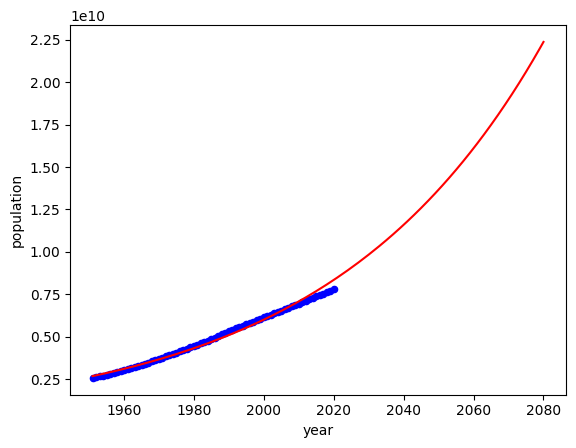

In [46]:
import requests
from bs4 import BeautifulSoup

url = 'https://www.worldometers.info/world-population/world-population-by-year/'

response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

table = soup.find('table')
rows = table.find_all('tr')

year_array = []
population_array = []
change_array = []

for row in rows[1:]:
    columns = row.find_all('td')
    year = columns[0].text.strip()
    if year == '1927':
        break
    population = columns[1].text.strip().replace(',', '')
    change = columns[2].text.strip().replace(',', '').replace('%', '')
    change_array.append(change)
    year_array.append(year)
    population_array.append(population)

change_array = np.array(change_array).astype('float')
change_array /= 100

# dist = distfit()
# dist.fit_transform(change_array)
# dist.plot()
# plt.savefig("Images/Global Population Growth Distribution.png", dpi = 1000)

# pred_year = 2080
# bin = 300
# y = pred_year - 2020 
# pred = []

# for i in range (bin):    
#     m_new = np.array(dist.generate(y)).astype('float')
#     pred.append(m_new)
    
year_array = np.array(year_array).astype('int')
population_array = np.array(population_array).astype('float')

df = pd.DataFrame({
    'year': year_array,
    'population': population_array
})
df.plot.scatter('year', 'population', color = 'Blue')

all_year_data = np.array([])
all_pop_data = np.array([])

# for p in pred:
#     pop = np.copy(population_array)
#     year_copy = np.copy(year_array)
#     for growth in p:
#         pop = np.insert(pop, 0, pop[0]*(1+growth))
#         year_copy = np.insert(year_copy, 0, year_copy[0] + 1)
#     all_pop_data = np.concatenate((all_pop_data, pop), axis = 0)
#     all_year_data = np.concatenate((all_year_data, year_copy), axis = 0)
#     plt.scatter(year_copy, pop, color = 'blue', label = 'Prediction', alpha = 0.5, s=0.5)

# df = pd.DataFrame({
#     'year': all_year_data,
#     'pop': all_pop_data
# })

# quantile = [0.25, 0.5, 0.75]
# for q in quantile:

#     xdata = []
#     ydata = []

#     for year in range(1951, pred_year + 1):
#         working_df = df[df['year'] == year] 
#         working_pop_array = working_df['pop'].values
#         q1 = np.quantile(working_pop_array, q)
#         xdata.append(year)
#         ydata.append(q1)
    
#     xdata = np.array(xdata)
#     ydata = np.array(ydata)
    
#     coefs = np.polyfit(xdata, np.log(ydata), deg=1)
#     k = coefs[0]
#     b = np.exp(coefs[1])
#     pred_y = exponential(xdata, k, b)
#     plt.plot(xdata, pred_y, '-', color = 'red')


coefs = np.polyfit(year_array-1951, np.log(population_array), deg=1)
k = coefs[0]
b = np.exp(coefs[1])
intarray = np.array([i for i in range (1951, 2081)]) 
pred_y = exponential(intarray-1951, k, b)
plt.plot(intarray, pred_y, '-', color = 'red')






plt.savefig('Images/Global Population Predict.png', dpi = 1000)



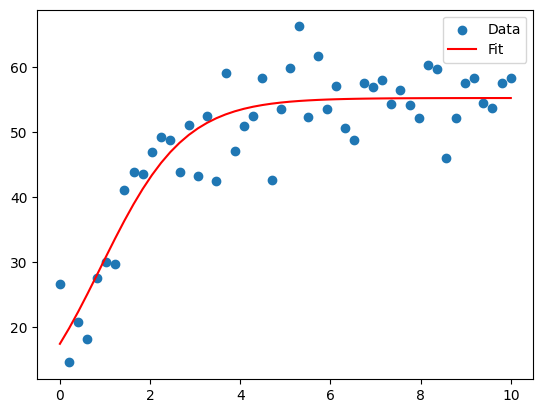

In [41]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# define the logistic growth function
def logistic(t, a, b, c, d):
    return c / (1 + a*np.exp(-b*t)) + d

# generate some random data
t_data = np.linspace(0, 10, 50)
y_data = logistic(t_data, 2.5, 1, 50, 5) + 5*np.random.normal(size=len(t_data))

# perform the polynomial fit
popt, pcov = curve_fit(logistic, t_data, y_data)

# plot the data and the fitted curve
plt.scatter(t_data, y_data, label='Data')
plt.plot(t_data, logistic(t_data, *popt), 'r-', label='Fit')
plt.legend()
plt.show()


outline for presentation:

introduction of the topic
importance of the topic
the results I obtained
the results compared with other predictions 
results methodology
question answered
quesntion unasnwered
leason learned
